In [1]:
%load_ext autoreload
%autoreload 2

# Cox proportional hazard model

Voor mijn verdiepende model ga ik mijn verdiepen in het "Cox Proportional hazard model". Dit is een niet lineair regressie model. Het plan voor dit onderzoek is het toepassen van een al gemaakte library, op een door kaggle vekregen dataset die later tevoorschijn komt. Om het model en de achterliggende werking te begrijpen zal ik ook een poging doen om het model na te maken, en deze dan vergelijken met de eerder benoemde library.

## Achtergrond informatie

Dit model valt onder een gebied is statistiek genaamd "Survival analysis". Deze hoek van statistiek houd zich bezich met het analyseren van resultaten die te maken hebben met een tijds-component (Deo et al., 2020). Bij outcome research wordt er vaak een hazard ratio bepaald doormiddel van het hazard model, deze wordt gebruikt om te bepalen of het onderzoek het gewilde effect gehad heeft.

Het Cox propertional hazard model (CPHM) is in 1972 bedacht door David Cox. Dit model kan gebruikt worden om het effect van meerdere continue en categorische variabelen op de survival te bepalen. Het kwantificeren van verschillen in survival verdelingen tussen groepen wordt gedaan door het berekenen van een hazard ratio. Deze ratio is de ratio van de trend van een gebeurtenis op elk mogelijk moment van 1 groep in verhouding tot de andere groep (Deo et al., 2021).

CPMH gebruikt de verschillende covariates (variabelen die mogelijk impact kunnen hebben op een event) samen met een bijbehorende coefficient (beta). Deze beta waarden representeren de log-hazard ratio van de bijbehorende covariate. Een positieve beta-value houd in dat de kans op het event (zoals bijvoorbeeld sterven) verhoogt. Een negatieve beta-value is dan ook geassocieerd met een lagere kans op het event. rond de 0 is geen verschil in kans. Als je een covariate age hebt met een beta-value van 0.2, houd in dat als age met 1 toeneemt er een 20% increase van de log-hazard van het event. Dit is in log scale, en kan lastig zijn om te interpreteren. Dit kan verbeterd worden door de beta value als een exponent voor e te nemen. Dit geeft de hazard ratio (HR). Een HR > 1 houd weer een increase van risk in. < 1 een decrease en rond de 1 blijft de risk gelijk.

## Data
Ik gebruik data van de R package genaamd "survival". De dataset gaat over longkanker en heb ik weggeschreven naar een csv bestand. Mijn plan is om langzaam de verschillende stappen van CPHM uit te werken op deze data. Met uitleg erbij over de stappen die gezet worden. Aller eerst moet er gekeken worden naar de data zelf. En mogelijk wat dingen veranderd worden. Deze dataverwerking ga ik uitvoeren met polars, deze library lijkt wat meer op R en is mijn voorkeur boven pandas.


In [2]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import drawStyles
import numpy as np
from math import e
sns.color_palette("tab10")
sns.set_theme("notebook", style="white")

In [3]:
df = pl.read_csv("lungcancer_survival.csv", has_header=True, null_values="NA")
df

inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
3,306,2,74,1,1,90,100,1175,null
3,455,2,68,1,0,90,90,1225,15
3,1010,1,56,1,0,90,90,null,15
5,210,2,57,1,1,90,60,1150,11
1,883,2,60,1,0,100,90,null,0
…,…,…,…,…,…,…,…,…,…
1,188,1,77,1,1,80,60,null,3
13,191,1,39,1,0,90,90,2350,-5
32,105,1,75,2,2,60,70,1025,5


De data is nu ingelezen. We zien een aantal vanzelfsprekende kolommen. Status is overleden of niet (1 en 2). Sex man:1 vrouw:2. Ik wil deze encodings graag omzetten naar 0 en 1 voor leesbaarheid.

De data bestaat uit 228 rijen, en 10 kolommen

In [4]:
df = df.with_columns(
    pl.col("status").replace([1,2], [0,1]),
    pl.col("sex").replace([1,2], [0,1])
)

df.head()

inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
3,306,1,74,0,1,90,100,1175,null
3,455,1,68,0,0,90,90,1225,15
3,1010,0,56,0,0,90,90,null,15
5,210,1,57,0,1,90,60,1150,11
1,883,1,60,0,0,100,90,null,0


Ook is er zichtbaar dat er verschillende NA waarden zijn. Ik wil graag bepalen hoeveel dit er zijn zodat ik kan bepalen of ik deze wil verwijderen, of imputeren.

In [5]:
sum(df.describe().row(1)[1:])

67.0

Hieruit blijkt het dat er 67 rijen zijn met een NA waarde. Omdat ik aardig krap zit met tijd voor deze opdracht besluit ik om deze eerst te verwijderen. Als er tijd oveblijft zal ik gaan kijken naar data imputatie.

In [6]:
df_nulless = df.drop_nulls()
df_nulless

inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
3,455,1,68,0,0,90,90,1225,15
5,210,1,57,0,1,90,60,1150,11
12,1022,0,74,0,1,50,80,513,0
7,310,1,68,1,2,70,60,384,10
11,361,1,71,1,2,60,80,538,1
…,…,…,…,…,…,…,…,…,…
11,203,0,71,1,1,80,90,1025,0
13,191,0,39,0,0,90,90,2350,-5
32,105,0,75,1,2,60,70,1025,5


Nu de data inprincipe schoon gemaakt is, kan ik weer verdiepen op survival analyses en het CPHM. Om eerst wat meer begrip te krijgen van survival analyses wil ik gaan kijken naar de Kaplan Meier curve. Deze curve geeft weer wat de survival probability is over tijd. Ik wil deze beter begrijpen door zelf een implementatie te maken in polars. Deze zal ik vervolgens vergelijken met een al gemaakte class uit de lifelines library.

In [7]:
from lifelines import KaplanMeierFitter

Ik ga eerst een simpel test setje maken, deze zal gebruikt worden om mijn en lifelines implementatie te vergelijken met elkaar.

<Axes: xlabel='timeline'>

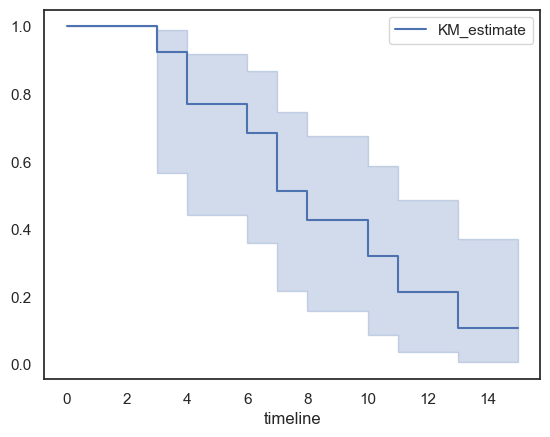

In [8]:
T = [3,4,4,4,6,7,7,8,9,10,11,13,15]
E = [1,1,1,0,1,1,1,1,0,1,1,1,0]

kmf = KaplanMeierFitter()
kmf.fit(T, event_observed = E)
kmf.plot_survival_function()

De verkregen plot van lifelines geeft de survival probability weer over de timeline die voorkomt in de data. Deze geeft weer dat hoe lang de tijd doorloopt, hoe meer de survival probability zal dalen. Ik ben van plan om de implementatie te baseren op wat ik vind op het internet. De bronnen hiervoor zullen vermeld worden. https://www.youtube.com/watch?v=L_ziqYhksG8.

### KaplanMeier implementatie
Lifelines implementatie gebruikt 2 arrays als input, eentje die de tijdlijn bevat en eentje die de censorings bevat. Dit wil ik ook gaan doen, maar dan als polars dataframe.

In [9]:
kaplan_input_df = pl.DataFrame({
    "time": T,
    "e": E
})
kaplan_input_df

time,e
i64,i64
3,1
4,1
4,1
4,0
6,1
…,…
9,0
10,1
11,1


Met deze dataframe kan ik de M, N en Q gaan berekenen. Ik zal hieronder uitleggen wat deze waarden inhouden.

- M: hoeveel events per tijd een waarde hebben van 1
- N: hoeveelheid subjects die op dat tijds-punt voor het event nog meedoen
- Q: hoeveelheid events per tijds-punt met een waarde van 0, als deze een M > 0 hebben. Anders zal deze het vorige tijds-punt opgeteld worden.

De verschillende stappen worden in het volgende code block toegepast.

In [10]:
result = (
    kaplan_input_df
    # Bereken de m (censor = 1) en q (censor = 0) aantallen voor elk tijds-punt
    .group_by("time")
    .agg(
        m = pl.col("e").sum().cast(pl.Int64),
        q = pl.col("e").eq(0).sum().cast(pl.Int64)
    ).sort("time")

    # Geef de censor van i+1 aan de q van i als m[i+]
    .with_columns(
        next_q = pl.when(pl.col("m").shift(1) > 0)
        .then(pl.col("q").shift(-1))
        .otherwise(0)
    )
    .with_columns(
        q = pl.when(pl.col("next_q").is_null() | pl.col("next_q") == 0)
        .then(pl.col("q"))
        .otherwise(pl.col("next_q"))
    )
    # Haal alle tijden met m < 0 weg.
    .filter(pl.col("m") > 0).drop("next_q")
    .vstack(pl.DataFrame({"time":[0], "m": [0], "q": [0]}))
    .sort("time")

    # Bereken de afname van subjects overtijd.
    .with_columns(
        total_subjects=pl.lit(len(kaplan_input_df)),
        cumulative_m=pl.col("m").cum_sum(),
        cumulative_q=pl.col("q").cum_sum()
    )
    .with_columns(
        n=pl.col("total_subjects") - pl.col("cumulative_m").shift(1) - pl.col("cumulative_q").shift(1)
    )
    .with_columns(
        n=pl.when(pl.col("time") == 0).then(pl.col("total_subjects")).otherwise(pl.col("n"))
    ).select(["time", "m", "q", "n"])
)

result

time,m,q,n
i64,i64,i64,i64
0,0,0,13
3,1,0,13
4,2,1,12
6,1,0,9
7,2,0,8
8,1,1,6
10,1,0,4
11,1,0,3
13,1,1,2


Hier wordt de survival probability berekend.

In [11]:
result = (
    result
    .with_columns(
        prob_survive = (pl.col("n") - pl.col("m")) / pl.col("n")
    ).with_columns(
    # Cumulative product starting from 1.0
    s = pl.col("prob_survive").cum_prod()
    ).drop("prob_survive")
)

result

time,m,q,n,s
i64,i64,i64,i64,f64
0,0,0,13,1.0
3,1,0,13,0.923077
4,2,1,12,0.769231
6,1,0,9,0.683761
7,2,0,8,0.512821
8,1,1,6,0.42735
10,1,0,4,0.320513
11,1,0,3,0.213675
13,1,1,2,0.106838


Met deze verkregen data kan je een step-plot maken. En deze kan vervolgens vergeleken worden met de lifelines implementatie.

<Axes: xlabel='time', ylabel='s'>

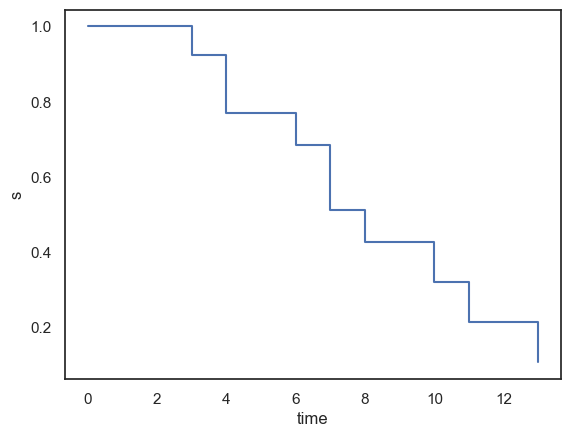

In [12]:
sns.lineplot(result, x = "time", y = "s", drawstyle='steps-post')

Deze grafiek komt goed overeen met de verkregen grafiek uit de lifelines library. Nu kan ik deze techniek gaan toepassen op de verkrgen lung cancer data. Hiervoor kan direct de df-nulless gebruikt worden. Alleen zullen de namen van de kolommen anders moeten heten.

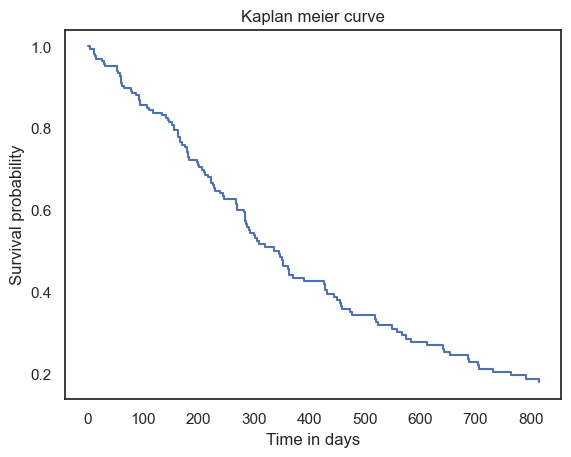

In [13]:
from classes.KaplanMeier import KaplanMeier
kaplanmeier = KaplanMeier()
null_less_kaplan_result = kaplanmeier.fit(df_nulless.select(["time", "status"]).rename({"status": "censored"}))

sns.lineplot(null_less_kaplan_result, x = "time", y = "s", drawstyle = "steps-post")
plt.xlabel("Time in days")
plt.ylabel("Survival probability")
plt.title("Kaplan meier curve")
plt.show()

Wat deze grafiek zichtbaar maakt is dat de survival probability heel erg snel daalt. Na 300 dagen zit deze al rond 50%. Vanaf 800 dagen zit deze op het laagste punt net onder 20%. Hetzelfde is zichtbaar in de grafiek hieronder van lifelines. Deze laat de lijn doorlopen tot het hoogste tijd punt in de data. Wat mijn implementatie momenteel niet doet. Voor de rest lijken de 2

<Axes: xlabel='timeline'>

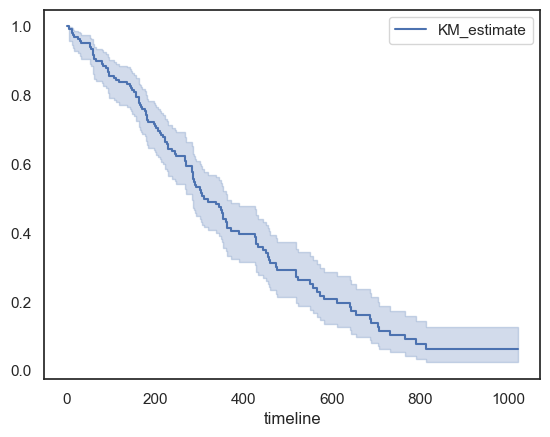

In [14]:
time = df_nulless["time"].to_list()
censored = df_nulless["status"].to_list()

KaplanMeierFitter().fit(time, event_observed = censored).plot_survival_function()

Deze data kan gebruikt worden om de hazard te berekenen, ofwel de kans dat een patient dood gaat tussen 2 tijd punten. (TileStats, 2023). Dit ga ik nu berekenen voor een hazard rate step plot.

<Axes: xlabel='time', ylabel='h'>

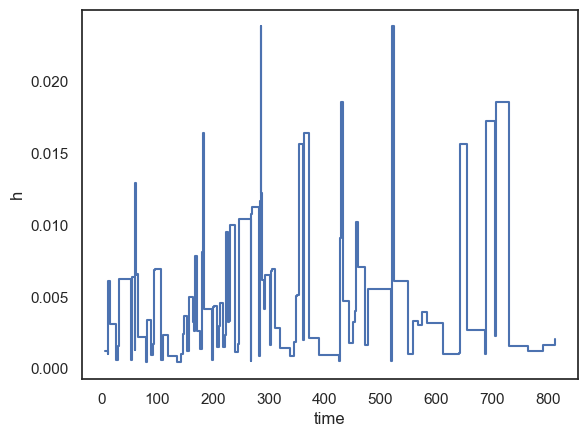

In [15]:
hazard_rate_data = (
    null_less_kaplan_result
    .with_columns(
        delta_time = pl.col("time")-pl.col("time").shift(1)
    ).filter(pl.col("delta_time").is_not_null())
    .with_columns(
        h = (pl.col("m") / pl.col("n") / pl.col("delta_time"))
    ).drop("delta_time")
)

sns.lineplot(hazard_rate_data, x = "time", y = "h", drawstyle = "steps-post")

<Axes: xlabel='time', ylabel='cum_hazard'>

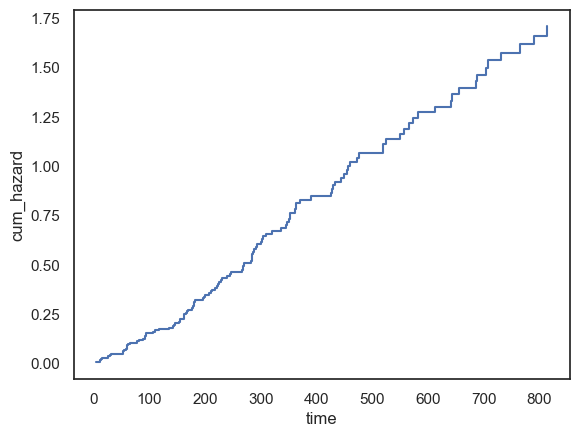

In [16]:
cum_hazard_rate = (
    hazard_rate_data
    .with_columns(
        delta_time = pl.col("time")-pl.col("time").shift(1).fill_null(0)
    )
    .with_columns(
        interval_contrib = pl.col("h") * pl.col("delta_time"),
    )
    .with_columns(
        cum_hazard = pl.col("interval_contrib").cum_sum()
    ).drop(["interval_contrib", "delta_time"])

)

sns.lineplot(cum_hazard_rate, x = "time", y = "cum_hazard", drawstyle = "steps-post")

## Hazard ratio
Nu ga ik de hazard ratio berekenen voor 2 verschillende groepen, man en vrouw. Eerst zal ik hiervoor een passende df gaan maken.
1 van de aannames die geldt voor het model is dat er geen ties mogelijk zijn. Dit houd in dat op een tijds punt t, er maar 1 patient een event mag ondergaan. Om het zo simpel mogelijk te houden ga ik een klein beetje random noise bij de tijd doen, zo verwijder ik alle ties.

In [17]:
df_nulless = df_nulless.with_columns(
     (pl.col("time") + pl.Series(np.random.normal(2, 1, df_nulless.height))).alias("times_noise")
)
df_nulless_male = df_nulless.filter(pl.col("sex") == 0).rename({"status": "censored"})
df_nulless_female = df_nulless.filter(pl.col("sex") == 1).rename({"status": "censored"})

df_nulless_female

inst,time,censored,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,times_noise
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64
7,310,1,68,1,2,70,60,384,10,312.892111
11,361,1,71,1,2,60,80,538,1,364.208099
1,61,1,56,1,2,60,60,238,10,65.431706
6,81,1,49,1,0,100,70,1175,-8,83.878588
12,520,1,70,1,1,90,80,825,6,520.458905
…,…,…,…,…,…,…,…,…,…,…
11,211,0,70,1,2,70,30,131,3,213.125099
2,175,0,57,1,0,80,80,725,11,179.301819
11,203,0,71,1,1,80,90,1025,0,204.300393


In [18]:
female_kaplan_meier = KaplanMeier().fit(df_nulless_female)
male_kaplan_meier = KaplanMeier().fit(df_nulless_male)

male_kaplan_meier = male_kaplan_meier.with_columns(
    sex = 0
)

female_kaplan_meier = female_kaplan_meier.with_columns(
    sex = 1
)
male_kaplan_meier = KaplanMeier().calc_hazard(male_kaplan_meier)
female_kaplan_meier = KaplanMeier().calc_hazard(female_kaplan_meier)

sex_seperated_kaplan_meier = pl.concat([male_kaplan_meier, female_kaplan_meier])

In [19]:
sex_seperated_kaplan_meier.head()

time,m,q,n,s,sex,h
i64,i64,i64,i64,f64,i32,f64
11,1,0,103,0.990291,0,0.000883
12,1,0,102,0.980583,0,0.009804
13,1,0,101,0.970874,0,0.009901
15,1,0,100,0.961165,0,0.005
26,1,0,99,0.951456,0,0.000918


Deze df bevat de survival probability voor beide genders, los berekend van elkaar. Ook bevatten deze de hazard.

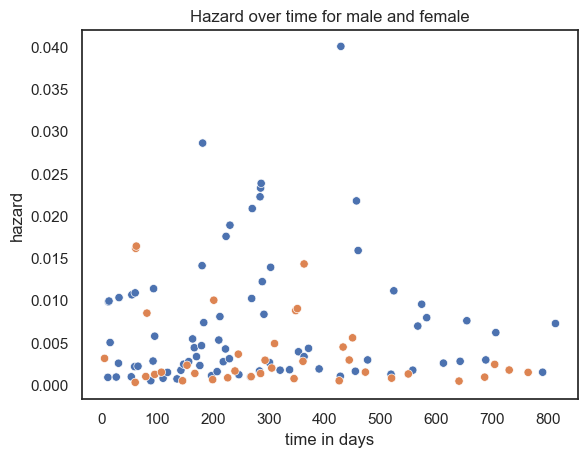

In [20]:
g = sns.scatterplot(sex_seperated_kaplan_meier, x = "time", y = "h", hue = "sex", legend=False)
plt.xlabel("time in days")
plt.ylabel("hazard")
plt.title("Hazard over time for male and female")
plt.show(g)

Nu komen we aan bij de CPHM. Deze maakt gebruik van een bepaalde hazard function die de risk weergeeft van een evenement bij een bepaald tijdspunt, gegeven dat dat event nog niet heeft plaats gevonden voor t. cox PH is handig voor wanneer data gecensureerd is, er wordt geen verdeling verwacht. En geeft makkelijk te intrepterende ratios terug. Hiervoor gebruiken we weer leeftijd als een verdeler tussen groepen, maar dit zou ook bijvoorbeeld treatment kunnen zijn. Ik wil mijn eigen implementatie gaan vergelijken met de lifelines variant. Die ik zo eerst ga testen.Nu komen we aan bij de CPHM. Deze maakt gebruik van een bepaalde hazard function die de risk weergeeft van een evenement bij een bepaald tijdspunt, gegeven dat dat event nog niet heeft plaats gevonden voor t. cox PH is handig voor wanneer data gecensureerd is, er wordt geen verdeling verwacht. En geeft makkelijk te intrepterende ratios terug. Hiervoor gebruiken we weer leeftijd als een verdeler tussen groepen, maar dit zou ook bijvoorbeeld treatment kunnen zijn. Ik wil mijn eigen implementatie gaan vergelijken met de lifelines variant. 

Het CPHM gebruikt partial likelihoods om een waarde te estimeren. Voor nu ga ik dit eerst namaken met multiple lineair regression


In [21]:
from sklearn.linear_model import LinearRegression
from math import exp, log
from scipy.optimize import minimize


In [22]:

male_kaplan_meier = male_kaplan_meier.with_columns(
    log_h = pl.col("h").log()
)

female_kaplan_meier = female_kaplan_meier.with_columns(
    log_h = pl.col("h").log())



In [23]:
model = LinearRegression()
model.fit(male_kaplan_meier["time"].to_numpy().reshape(-1,1), male_kaplan_meier["log_h"].to_numpy())
baseline_intercept = model.intercept_
baseline_coef = model.coef_

model.fit(female_kaplan_meier["time"].to_numpy().reshape(-1,1), female_kaplan_meier["log_h"].to_numpy())
non_baseline_intercept = model.intercept_
non_baseline_coef = model.coef_

beta = non_baseline_intercept - baseline_intercept
hazard_ratio = exp(beta)
print(beta)
print(hazard_ratio)

-0.2830258397710068
0.7535003173325079


Volgens deze lineaire regressie ontstaat er een hazard ratio van ~0.75 dit houd in dat er een afname is van hazard bij de niet-baseline (vrouwen). De hazard is 0.75 keer kleiner bij vrouwen dan bij mannen. We zien ook wel bij de grafiek die de hazard weergeeft voor beide genders, dat de hazard bij mannen hoger spiken dan bij vrouwen.

In [285]:
from lifelines import CoxPHFitter

In [25]:
cph = CoxPHFitter()

cph.fit(df_nulless.drop("time").to_pandas(), "times_noise", "status")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 167 total observations, 47 right-censored observations>
             duration col = 'times_noise'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 167
number of events observed = 120
   partial log-likelihood = -491.37
         time fit was run = 2026-01-20 12:19:27 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
inst      -0.03      0.97      0.01           -0.06           -0.00                0.95                1.00
age        0.01      1.01      0.01           -0.01            0.04                0.99                1.04
sex       -0.56      0.57      0.20           -0.96           -0.17                0.38                0.84
ph.ecog    0.91      2.48      0.24            0.44            1.37                1.55                3.95
ph.karno   0.03      1.03      0.01            0.00            0.05                1.00                1.05
pat.karno -0.01      0.99      0.01           -0.03            0.01                0.97                1.01
meal.cal  -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
wt.loss   -0.02      0.98      0.01           -0.03           -0.00                0.97                1.00

           cmp to     z      p  -log2(p)
covariate                               
inst         0.00 -2.29   0.02      5.52
age          0.00  1.08   0.28      1.82
sex          0.00 -2.80   0.01      7.63
ph.ecog      0.00  3.80 <0.005     12.75
ph.karno     0.00  2.29   0.02      5.52
pat.karno    0.00 -1.32   0.19      2.43
meal.cal     0.00 -0.01   1.00      0.01
wt.loss      0.00 -2.10   0.04      4.82
---
Concordance = 0.65
Partial AIC = 998.74
log-likelihood ratio test = 33.44 on 8 df
-log2(p) of ll-ratio test = 14.25

In [26]:
cph.params_

covariate
inst        -0.030098
age          0.012841
sex         -0.564667
ph.ecog      0.906809
ph.karno     0.026692
pat.karno   -0.010769
meal.cal    -0.000002
wt.loss     -0.016670
Name: coef, dtype: float64

Ik wil eerst de negatieve log partial likelihood implementeren via de wikipedia pagina (https://en.wikipedia.org/wiki/Proportional_hazards_model#Software_implementations) Deze website geeft een nep datasetje, die ik zal gebruiken voor de partial likelihood voor binaire data, zoals ziekenhuis.

In [27]:
test_df = pl.DataFrame({
    "hospital" : ["B", "B","B", "B","B",  "A", "A", "A", "A", "A", "A", "A"],
    "X": [0,0,0,0,0,1,1,1,1,1,1,1],
    "T" : [60, 32, 60, 60, 60, 4, 18, 60, 9, 31, 53, 17],
    "C": [0, 1, 0,0,0,1,1,0,1,1,1,1]})
test_df
CoxPHFitter().fit(test_df.drop("hospital").to_pandas(), "T", "C").params_

covariate
X    2.118374
Name: coef, dtype: float64

Volgens de lifelines fitter zal de beta-value van de X covariate rond de 2.12 moeten liggen. Ik ga kijken of ik het algoritme zo kan implenteren dat ik er in de buurt van kom. Het doel is om de negatieve log partial likelihood te maximaliseren, zo krijg je de best passende beta-value. 

In [28]:
beta_values = []
partial_lll = []

for i in np.arange(0, 10, 0.01):
    beta_value = i
    partial_ll = []
    partial_u = []
    events = []
    
    for time in test_df["T"]:
        risk_set = test_df.filter(pl.col("T") >= time)
        if 1 in risk_set["C"]:
    
            event = risk_set.filter(pl.col("T") == time).select("X").item()
            events.append(event)
            test0 = risk_set.filter(pl.col("X") == 0).select("X").to_numpy()
            test1 = risk_set.filter(pl.col("X") == 1).select("X").to_numpy()
            calc = np.log(np.exp(event * beta_value)) - np.log(test0.size * np.exp(beta_value * 0) + test1.size * np.exp(beta_value * 1))
            partial_ll.append(calc)
    partial_lll.append(sum(partial_ll))
    beta_values.append(beta_value)


In [29]:
partial_lll.index(max(partial_lll))
beta_values[partial_lll.index(max(partial_lll))]

np.float64(2.12)

Hier zien we dat uit de range van 0-10 met stapjes van 0.01 het gemaakte scriptje de best mogelijke beta-value heeft gevonden: 2.12. Dit is het dichtsbij de value gevonden door lifelines. Op deze data lijkt het gemaakte scriptje aardig over te komen.

In [30]:
CoxPHFitter().fit(df_nulless.drop("time").to_pandas(), "times_noise", "status").params_

covariate
inst        -0.030098
age          0.012841
sex         -0.564667
ph.ecog      0.906809
ph.karno     0.026692
pat.karno   -0.010769
meal.cal    -0.000002
wt.loss     -0.016670
Name: coef, dtype: float64

Hier test ik de negative log likelihood op mijn eigen data, specifiek de gender van de patient. De beta value moet in de buurt van -.57 liggen om de hoogste negatieve log te krijgen. Het is niet exact hetzelfde als die van lifelines, maar close enough dat ik het zo laat. 

In [31]:
beta_values = []
partial_lll = []

for i in np.arange(-1, 1, 0.1):
    partial_ll = []
    partial_u = []
    events = []
    beta_value = i
    for time in df_nulless["times_noise"]:
        risk_set = df_nulless.filter(pl.col("times_noise") >= time)
        if 1 in risk_set["status"]:
        
            event = risk_set.filter(pl.col("times_noise") == time).select("sex").item()
            events.append(event)
            test0 = risk_set.filter(pl.col("sex") == 0).select("sex").to_numpy()
            test1 = risk_set.filter(pl.col("sex") == 1).select("sex").to_numpy()
            calc = np.log(np.exp(event * beta_value)) - np.log(test0.size * np.exp(beta_value * 0) + test1.size * np.exp(beta_value * 1))
            partial_ll.append(calc)
    partial_lll.append(sum(partial_ll))
    beta_values.append(beta_value)


In [32]:
partial_lll.index(max(partial_lll))
beta_values[partial_lll.index(max(partial_lll))]

np.float64(-0.20000000000000018)

Nu moet er gekeken worden naar covariates die continue zijn. Ook hiervoor gebruik ik een dataset verkregen van wikipedia

In [33]:
df_continue_test = pl.DataFrame({
    "Co.": list(range(12)),
    "1 year IPO date": [
        "2000-11-05", "2000-12-01", "2011-01-05", "2010-05-29", 
        "2005-06-23", "2000-06-10", "2011-07-11", "2007-09-27",
        "2006-07-30", "2000-07-13", "2013-06-10", "2011-07-16"
    ],
    "Death date*": [
        "2011-01-22", "2003-03-30", "2012-03-30", "2011-02-22",
        "2022-01-01", "2002-07-24", "2014-05-01", "2022-01-01",
        "2010-06-03", "2001-07-19", "2018-10-10", "2014-08-15"
    ],
    "C": [1,1,1,1,0,1,1,0,1,1,1,1],
    "T": [3730, 849, 450, 269, 6036, 774, 1025, 5210, 
          1404, 371, 1948, 1126],
    "P/E": [9.7, 12.0, 3.0, 5.3, 10.8, 6.3, 11.6, 10.3, 
            8.0, 4.0, 5.9, 8.3]
})

In [34]:
partial_ll = []
beta_value = -0.34
for time in df_continue_test["T"]:
    risk_set = df_continue_test.filter(pl.col("T") >= time)
    if 1 in risk_set["C"]:
        
        current_val = risk_set.filter(pl.col("T") == time).select("P/E").item()
        sum_test = []
        for unique_value in risk_set["P/E"].unique():
            filter_temp = risk_set.filter(pl.col("P/E") == unique_value).select("P/E").to_numpy()
            sum_test.append(filter_temp.size * np.exp(beta_value * unique_value))
        calc = np.log(np.exp(current_val * beta_value)) - np.log(sum(sum_test))
        partial_ll.append(calc)

In [35]:
sum(partial_ll)

np.float64(-16.671386239004455)

In [36]:
def log_sum_exp(values, weights=None):
    max_val = np.max(values)
    if weights is None:
        weights = np.ones_like(values)
    return np.log(np.sum(weights * np.exp(values - max_val))) + max_val

Om dit makkelijker te gebruiken wil ik dit omzetten naar een algemene functie, die werkt voor zowel een binaire als continue covariaat.

In [37]:
def calc_neg_log_partial_likelihood(df, time_col, event_col, covariate, beta_value = 0):
    partial_ll = []
    for time in df[time_col].unique():
        if df.filter(pl.col(time_col) == time).select(event_col).item() == 1:
            risk_set = df.filter(pl.col(time_col) >= time)
            
            current_val = risk_set.filter(pl.col(time_col) == time).select(covariate).item()
            events.append(event)
            sum_test = []
            unique_values = risk_set[covariate].unique()
            counts = [risk_set.filter(pl.col(covariate) == val).height for val in unique_values]

            sum_test_safe = log_sum_exp(beta_value * np.array(unique_values), np.array(counts))

            calc = current_val * beta_value - sum_test_safe
            partial_ll.append(calc)
    return sum(partial_ll)

Deze werkt alleen wanneer er geen ties zijn in de tijd. Dus wanneer elk punt in de tijd uniek is. Er zijn meerdere manieren om dit te doen, die van makkelijk tot moeilijk gaan. Ik heb gekozen voor de zelfde implementatie als die van lifelines, Breslow's approximation. https://myweb.uiowa.edu/pbreheny/7210/f15/notes/11-5.pdf. Deze approximatie houd rekening met tied times, en zal nog 1 extra stap toevoegen aan het algoritme, de sum van het aantal events die 1 zijn op die tied time * exp(beta_value * unieke covariate value) - het aantal events at time j.
Ik ga hiervoor een nieuwe functie maken.

In [38]:
calc_neg_log_partial_likelihood(df_continue_test, "T", "C", "P/E", -0.34)

np.float64(-16.671386239004455)

In [39]:
def calc_neg_log_partial_likelihood_breslow(df, time_col, event_col, covariate, beta_value = 0):
    partial_ll = []
    for time in df[time_col].unique():
        if 1 in df.filter(pl.col(time_col) == time)[event_col]:
            risk_set = df.filter(pl.col(time_col) >= time)
            tied_times = df.filter(pl.col(time_col) == time)

            sum_test = []
            for unique_value in risk_set[covariate].unique():
                filter_temp = risk_set.filter(pl.col(covariate) == unique_value).select(covariate).to_numpy()
                sum_test.append(filter_temp.size * np.exp(beta_value * unique_value))
            # Covariates van alle events bij een tied time.
            tied_times_events = tied_times.filter(pl.col(event_col) == 1).select(covariate)
            # Sum van deze covariate values * beta_value - het aantal 1tjes als event bij de tied time.
            calc = sum(tied_times_events * beta_value) - sum(tied_times[event_col]) * np.log(sum(sum_test))
            partial_ll.append(calc.item())
    return sum(partial_ll)

In [40]:
beta_values = []
partial_lll = []

for i in np.arange(-5, 5, 0.01):
    beta_val = i
    partial_lll.append(calc_neg_log_partial_likelihood_breslow(test_df, "T", "C", "X", beta_val))
    beta_values.append(beta_val)
partial_lll.index(max(partial_lll))
beta_values[partial_lll.index(max(partial_lll))]

np.float64(2.1199999999998482)

Deze functie kan nu gebruikt worden om de negative log partial likelihood te berekenen bij een gegeven beta-value voor een covariant. Deze zal ook werken wanneer er ties in tijd zijn. De volgende stap is het implementeren van een algoritme die deze beta-value kan optimaliseren en op die manier de hoogst mogelijke vinden. Hiervoor is een score-functie nodig. Ik wil deze eerst implementeren voor de normale CPHM, en daarna breslow. De score functie staat op de al eerder benoemde wikipedia pagina. 

In [160]:
def score_normal_CPHM(current_covariate, relative_risk, covariate):
    
    sum_relative_time_cov = np.sum(relative_risk * covariate)
    return current_covariate - sum_relative_time_cov / sum(relative_risk)
    

In [262]:
def hessian_matrix_normal(relative_risk, covariates):
    relative_risk = relative_risk.astype(np.float64)
    rr_sum = np.sum(relative_risk)

    weighted_cov = covariates.T @ (relative_risk[:, None] * covariates)

    weighted_sum = (relative_risk[:, None] * covariates).sum(axis = 0)
    hessian = weighted_cov / rr_sum - np.outer(weighted_sum, weighted_sum) / (rr_sum ** 2)
    return hessian

In [43]:
def get_beta_value_score_normal(df, time_col, event_col, covariate, beta_value = 0):
    score_list = []
    variated_list = []
    for time in df[time_col].unique():
        if df.filter(pl.col(time_col) == time).select(event_col).item() == 1:
            risk_set = df.filter(pl.col(time_col) >= time)
            
            current_val = risk_set.filter(pl.col(time_col) == time).select(covariate).item()
            relative_risk = []
            for row in risk_set.iter_rows(named=True):
                relative_risk.append(np.exp(beta_value * row[covariate]))
            calc = score_normal_CPHM(current_val, relative_risk, risk_set[covariate].to_numpy())
            score_list.append(calc)
    return score_list

In [44]:
test = pl.DataFrame({
    "X" : [0,1,1,0],
    "T": [5,8,12,15],
    "C": [1,0,1,1]
})

In [45]:
x = get_beta_value_score_normal(test, "T","C", "X", 0)
x

[np.float64(-0.5), np.float64(0.5), np.float64(0.0)]

B kan geupdate worden via de Newton-raphson methode. Hiervoor heb je een score functie nodig, en de first differentiale formule van deze berekening. Deze zal ik hieronder uitwerken.

In [46]:
def _test(df, time_col, event_col, covariate, beta_value = 0):
    score_list = []
    variated_list = []
    X_LIST = []
    return_list = []
    for time in df[time_col].unique():
        if df.filter(pl.col(time_col) == time).select(event_col).item() == 1:
            risk_set = df.filter(pl.col(time_col) >= time)
            
            current_val = risk_set.filter(pl.col(time_col) == time).select(covariate).item()
            relative_risk = []
            for row in risk_set.iter_rows(named=True):
                relative_risk.append(np.exp(beta_value * row[covariate]))
            relative_risk_covariate = risk_set.select(pl.col(covariate)).to_numpy()

            x= hessian_matrix_normal(np.array(relative_risk), risk_set[covariate].to_numpy())
            return_list.append(sum(x))
    return return_list
-sum(_test(test, "T","C", "X",0))


array([-0.5])

Dit kan gebruikt worden om de beta value up te daten. beta = beta + score / _test

In [47]:
def get_score_and_test_based_on_beta(df, time_col, event_col, covariate, beta_value = 0):
    score_list = []
    variated_list = []
    X_LIST = []
    return_list = []
    for time in df[time_col].unique():
        if df.filter(pl.col(time_col) == time).select(event_col).item() == 1:
            risk_set = df.filter(pl.col(time_col) >= time)
            
            current_val = risk_set.filter(pl.col(time_col) == time).select(covariate).item()
            relative_risk = []
            risk_covariates = risk_set[covariate].to_numpy()
            max_val = beta_value * np.max(risk_covariates)
            for row in risk_set.iter_rows(named=True):
                relative_risk.append(np.exp(beta_value * row[covariate] - max_val))

            calc_score = score_normal_CPHM(current_val, relative_risk, risk_set[covariate].to_numpy())
            score_list.append(calc_score)

            # Calc differential
            x= hessian_matrix_normal(np.array(relative_risk), risk_set[covariate].to_numpy())
            return_list.append(sum(x))
    return score_list, return_list

In [48]:
CoxPHFitter().fit(df_continue_test.drop(["Death date*", "1 year IPO date"]).to_pandas(), "T", "C").params_

covariate
Co.   -0.088931
P/E   -0.379857
Name: coef, dtype: float64

-0.37 voor PE, nu ben ik benieuwd wat voor beta wordt gevonden door mijn implementatie.


In [49]:

beta_values = []
log_likeli_ = []

beta = 00000.1
for x in range(0, 100):
    beta_values.append(beta)
    log_likeli_.append(calc_neg_log_partial_likelihood(df_continue_test, "T","C", "P/E", beta))
    score_list, der_list = get_score_and_test_based_on_beta(df_continue_test, "T","C", "P/E", beta)
    beta = beta + np.sum(score_list) / np.sum(der_list)
    

In [50]:
beta_values[log_likeli_.index(max(log_likeli_))]

np.float64(-0.3350443812249321)

Hieruit blijkt een kleine afwijking van 0.03 verschil.

In [265]:
def get_score_and_test_based_on_beta_contin(df, time_col, event_col, covariate, beta_value = 0):
    score_list = []
    return_list = []
    partial_ll = []
    for row in df.sort(time_col).iter_rows(named = True):
        if row[event_col] == 1:
            time = row[time_col]
            risk_set = df.filter(pl.col(time_col) >= time)
            tied_times = df.filter(pl.col(time_col) == time)
            current_val = row[covariate]
            relative_risk = []
            risk_covariates = risk_set[covariate].to_numpy()
            max_val = beta_value * np.max(risk_covariates)
            for row in risk_set.iter_rows(named=True):
                relative_risk.append(np.exp(beta_value * row[covariate] - max_val))
            calc_score = score_normal_CPHM(current_val, relative_risk, risk_set[covariate].to_numpy())
            score_list.append(calc_score)
            # Calc differential
            x= hessian_matrix_normal(np.array(relative_risk), risk_set[covariate].to_numpy())
            return_list.append(np.sum(x))

            # Calc partial ll
            tied_times_events = tied_times.filter(pl.col(event_col) == 1).select(covariate)
            # Sum van deze covariate values * beta_value - het aantal 1tjes als event bij de tied time.
            calc_ll = sum(tied_times_events * beta_value) - sum(tied_times[event_col]) * np.log(sum(sum_test))
            partial_ll.append(calc_ll.item())
    return score_list, return_list, partial_ll

In [269]:
beta_values = []
log_likeli_ = []
eps = np.finfo(np.float32).eps
beta = 0.00
for x in range(0, 1):
    beta_values.append(beta)
    score_list, der_list, partial_ll = get_score_and_test_based_on_beta_contin(test_df.sort("T"), "T","C", "X", beta)
    log_likeli_.append(sum(partial_ll))
    print(der_list)
    beta_new = beta + np.sum(score_list) / np.sum(der_list)
    if np.abs(beta_new - beta) < eps:
        break
    beta = beta_new
    
    

[np.float64(0.24305555555555558), np.float64(0.2479338842975206), np.float64(0.25), np.float64(0.24691358024691357), np.float64(0.234375), np.float64(0.20408163265306123), np.float64(0.2222222222222222)]


In [59]:
beta_values

[0.0,
 np.float64(1.7789350363712115),
 np.float64(2.0849826681252326),
 np.float64(2.118000376369509),
 np.float64(2.1183749351217656)]

Ook hier wordt een overeenkomst gevonden met de nieuwe functie die werkt op data met tied times. Dit ga ik nu in de klasse implementeren.

In [391]:
import importlib
from classes.CoxProportionalHazard import CoxProportionalHazard
importlib.reload(cph)

model = CoxProportionalHazard()
model.fit(test_df.drop("hospital"), "T", "C")

array([2.11837498])

Het gemaakte model werkt met 1 covariate, ik ga nu kijken of ik ook 2 covariates kan gebruiken!


In [311]:
placeholder = [0,0,0,0,0,1,1,1,1,1,1,1]
placeholder.reverse()
test_df_multivariate = test_df.with_columns(
    X2 = pl.col("X").reverse()
)

# Ik ga dit eerst vergelijken met de lifelines class.
model = CoxPHFitter()

model.fit(test_df_multivariate.drop("hospital").to_pandas(), "T", "C")
model.print_summary()

<lifelines.CoxPHFitter: fitted with 12 total observations, 5 right-censored observations>
             duration col = 'T'
                event col = 'C'
      baseline estimation = breslow
   number of observations = 12
number of events observed = 7
   partial log-likelihood = -11.53
         time fit was run = 2026-01-20 13:36:09 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
X          3.33     27.98      1.39            0.61            6.05                1.84              424.77
X2         1.42      4.13      1.02           -0.59            3.42                0.56               30.70

           cmp to    z    p  -log2(p)
covariate                            
X            0.00 2.40 0.02      5.93
X2           0.00 1.39 0.17      2.60
---
Concordance = 0.79
Partial AIC = 27.06
log-likelihood ratio test = 7.34 on 2 df
-log2(p) of ll-ratio test = 5.30

De covariates hebben invloed op elkaar, ik hoop dat ook te kunnen zien in mijn versie van het model.

In [403]:
import classes.CoxProportionalHazard as cph2
importlib.reload(cph2)

model = cph2.CoxProportionalHazard()
model.fit(test_df_multivariate.drop("hospital"), "T", "C")

0
[0. 0.]
[4.36198654 2.98605395]
1.1920929e-07


array([3.3315497 , 1.41918649])

In [ ]:
Heruit blijkt dat de coefficienten gevonden zijn door mijn model exact overkomen met het lifelines model! 

In [405]:
CoxPHFitter().fit(df_nulless.drop("times_noise").to_pandas(), "time", "status").params_

covariate
inst        -0.030368
age          0.012810
sex         -0.566628
ph.ecog      0.907373
ph.karno     0.026584
pat.karno   -0.010911
meal.cal     0.000003
wt.loss     -0.016711
Name: coef, dtype: float64

In [411]:
import classes.CoxProportionalHazard as cph2
importlib.reload(cph2)

model = cph2.CoxProportionalHazard()

for value in model.fit(df_nulless.drop("times_noise"), "time", "status"):
    print(value)

-0.03029041341984357
0.012767466192359241
-0.5656228272572389
0.9058672422331201
0.026552816822496043
-0.010906768061293062
2.5935967058702584e-06
-0.01662944742078007
